In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
import torch
import numpy as np
from scipy.spatial.distance import pdist, cdist
%matplotlib inline 
import matplotlib.pyplot as plt

In [3]:
# Plotting.
def show(data):
    plt.imshow(data)
    plt.colorbar()
    plt.show()

In [4]:
# Kernel function stuff...
def rbf_kernel(A, B, scale=1.0):
    sq_dists = torch.cdist(A, B) ** 2 
    return torch.exp(-sq_dists / (2 * scale ** 2))

In [5]:
# Testing.
# Get n x 2 coordiante matrix D.
def get_coordinates_uniform(radius, num_each_dir):
    x = torch.linspace(-radius, radius, num_each_dir, device='cuda')
    y = x.clone()
    xg, yg = torch.meshgrid(y, x, indexing='ij')
    xf, yf = xg.flatten(), yg.flatten()
    D = torch.column_stack([xf, yf])
    return D

# Get f(x, y), f_x + noise, f_y + noise.
def test_surface_data(D, noise):
    # Surface is z = x^2 + y^2.
    xf, yf = D[:, 0], D[:, 1]
    zf = 0.1 * (xf ** 2 + yf ** 2)

    # Get noisy gradient data.
    zxf = 0.2 * xf + noise * torch.randn_like(xf)
    zyf = 0.2 * yf + noise * torch.randn_like(yf)
    g = torch.cat([zxf, zyf])

    # Return true surface and noisy gradient as vectors.
    return [zf, g]

# Get stuff needed for the regression.
# For right now, assume Kernel is RBF.

# Build matrix theta_ij = phi_i(phi_j(K((x1, x2), (y1, y2)))).
# X is a n x 2 matrix if (x, y) coordinates.
def build_theta(X, scale=1):
    # Get K(X, X).
    K = rbf_kernel(X, X, scale)

    # Isolate coordinates.
    xcoords = X[:, 0]
    ycoords = X[:, 1]
    dx = xcoords[:, None] - xcoords[None, :]
    dy = ycoords[:, None] - ycoords[None, :]

    # Get constants.
    inv_scale2 = 1 / (scale ** 2)
    inv_scale4 = inv_scale2 ** 2
    
    # Make the 4 n x n block matrices.
    top_left = (K * inv_scale2) * (1 - inv_scale2 * dx ** 2)
    top_right = -inv_scale4 * dx * dy * K
    bottom_left = top_right.clone().T
    bottom_right = (K * inv_scale2) * (1 - inv_scale2 * dy ** 2)

    # Stack into 2n x 2n matrix.
    top = torch.cat([top_left, top_right], dim=1)
    bottom = torch.cat([bottom_left, bottom_right], dim=1)
    Theta = torch.cat([top, bottom], dim=0)
    return Theta

# Find z to minimize ||Theta @ z - g||^2 + (lambda / 2) * z^T Theta^-1 z.
# Then alpha = Theta^-1 z.
def compute_alpha(Theta, g, _lambda):
    # Assuming symmetric Theta this makes sense.
    # ------------------------------------------
    # # Solve for z.
    # Theta2 = Theta @ Theta
    # Theta3 = Theta2 @ Theta
    # Id = np.eye(Theta.shape[0])
    # z = np.linalg.solve(2 * Theta3 + _lambda * Id, 2 * Theta2 @ g)
    # ------------------------------------------

    # Below works even if Theta isn't symmetric!
    # ------------------------------------------
    # Gradient with respect to z.
    # 2 Theta^T (Theta @ z - g) + lambda Theta^{-1} z 
    # Set equal to zero.
    # You get (2 Theta^T @ Theta + lambda Theta^-1)z = 2 Theta^T @ g 
    # Since alpha = Theta^-1 @ z we can distribute to get:
    # (2 Theta^T @ Theta^2 + lambda I) @ alpha = 2 Theta^T @ g 
    I = torch.eye(Theta.shape[0], device='cuda')
    alpha = torch.linalg.solve(2 * Theta.T @ Theta @ Theta + _lambda * I, 2 * Theta.T @ g)

    return alpha

def eval_model(Xeval, X, alpha, scale):
    # X is our n x 2 (x, y) data points.
    # Xeval is our m x 2 (x, y) points we want to evaluate our model.
    K = rbf_kernel(Xeval, X, scale)

    # Get coords.
    xcoords_eval = Xeval[:, 0]
    xcoords = X[:, 0]
    ycoords_eval = Xeval[:, 1]
    ycoords = X[:, 1]

    # Get diffs.
    xdiff = xcoords_eval[:, None] - xcoords[None, :]
    ydiff = ycoords_eval[:, None] - ycoords[None, :]

    # Get G.
    G_top = (xdiff / (scale ** 2)) * K
    G_bottom = (ydiff / (scale ** 2)) * K
    G = torch.cat([G_top.T, G_bottom.T], dim=0)
    print(G.shape)

    # Get evaluation.
    _eval = alpha @ G

    return _eval

In [14]:
n = 10
scale = 5
D = get_coordinates_uniform(radius=1, num_each_dir=n)
Theta = build_theta(X=D, scale=scale)
[zf, g] = test_surface_data(D=D, noise=1e-1)
alpha = compute_alpha(Theta=Theta, g=g, _lambda=1e-3)

torch.Size([200, 100])


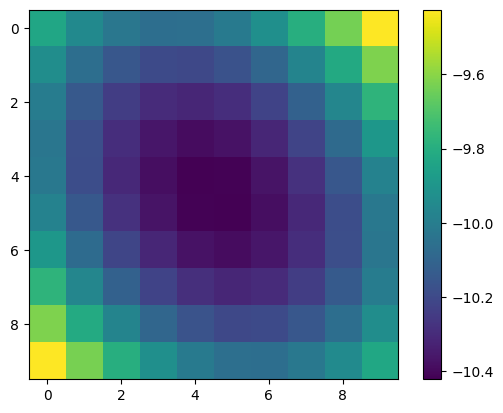

In [15]:
surf = eval_model(Xeval=D, X=D, alpha=alpha, scale=scale)
surf = surf.reshape((n, n))
surf = surf.cpu().numpy()
show(surf)

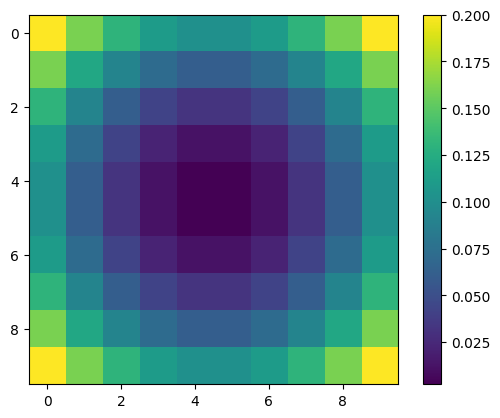

In [16]:
surf_true = zf.reshape((n, n))
surf_true = surf_true.cpu().numpy()
show(surf_true)

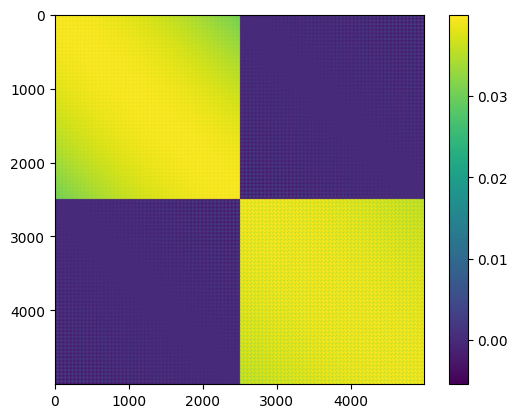

In [9]:
show(Theta.cpu().numpy())